### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/3_Temporal-Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, run_experiment_episode_train

### Run locally

In [1]:
from rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, run_experiment_episode_train

### Objective
Here we present methods to solve the problem of environment and agents when the model is not known and not used (model-free).

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt
env = gym.make('FrozenLake-v0')

In [ ]:
def run_experiment_episode_train(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            agent.train(current_state, action, reward, state, done)
            rews.append(reward)
        rewards[i] = sum(rews)
        print('episode: {} - cum reward {}'.format(i, rewards[i]))
    return rewards

# Usefull tools
Many times, it will be necessary for us to calculate the discount return $G_t = \sum_{k=0}^T\gamma^k R_{t+k+1}$. For that, we use optimized discount_cumsum function. Example

In [15]:
episode_reward = [0,0,0,1,0,0,0,-.3,0,1,1,0,10]
gamma = 0.9
discount_cumsum(episode_reward, gamma)

array([ 4.14590522,  4.60656136,  5.11840151,  5.68711279,  5.2079031 ,
        5.786559  ,  6.42951   ,  7.1439    ,  8.271     ,  9.19      ,
        9.1       ,  9.        , 10.        ])

In many cases, we will need to compute the disount rewards through multiple episodes:

In [5]:
#TODO: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=500):
    discount_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_returns.append(None)#complete here
    return np.hstack(discount_returns)

In [6]:
#Done: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=50):
    discount_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_returns.append(discount_cumsum(rewards, gamma))
    return np.hstack(discount_returns)

In [7]:
res = get_G(env)
res.shape

(316,)

And to compute the trajectories $(S,A,R,G)_\pi$:

In [8]:
#TODO: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(None) # complete here
    return np.vstack(trajectories)

In [11]:
#Done: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(np.c_[discount_return.reshape(-1,1), episode])
    return np.vstack(trajectories)

In [12]:
res = get_trajectories(env)
print(res.shape)
#print('states' : res[:,0])
#print('actions' : res[:,1])
#print('rewards' : res[:,2])
#print('cumulative discounted rewards' : res[:,3])

(426, 4)


# Monte-Carlo Methods

Now, considering an environment without knowing its transition model, we want to build a smart agent, a free model based agent.
The naive approach is to estimate the Q function using monte-carlo estimation.
As we know:
\begin{aligned}
V_{\pi}(s) &= \mathbb{E}[G_t \vert S_t = s] = \frac{1}{P(S_t=s)}E[G_t \mathbb{1}_{S_t=s}] \\
Q_{\pi}(s, a) &= \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]
\end{aligned}
We compute the empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$, following policy $\pi$.
From law of large numbers the estimators:
\begin{aligned}
V_{\pi}(s) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s]}\\
Q(s, a) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a]}
\end{aligned}

remember Incremental mean:
\begin{aligned}
\mu_K &= \frac{1}{K}\sum_{j=1}^K X_j\\
\mu_K &= \frac{1}{K}[X_K + \sum_{j=1}^{K-1} X_j]\\
\mu_K &= \frac{1}{K}[X_K + (K-1)\mu_{K-1}]\\
\mu_K &= \mu_{K-1} + \frac{1}{K}(X_K -\mu_{K-1})\\
\end{aligned}
As well:
\begin{aligned}
\mu_K &= \mu_{K-p} + \frac{1}{K}(\sum_{K-p}^K X_k - p\mu_{K-p})\\
\end{aligned}
We do the same to update incrementally at each episode the empirical $V$. For each state $S_t$ with return $G_t$:
\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \frac{1}{N_{\text{total}}(S_t)}(G_t - N_{\text{trajectory}}(S_t)V(S_t))\\
\end{aligned}

In [13]:
#TODO: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                Gt_state = discount_return[episode[:,0] == state].sum()
                V[state] += None #complete here
    return V

In [14]:
#Done: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                V[state] += (discount_empirical_return[episode[:,0] == state].sum() - N_trajectory[state] * V[state]) / count
    return V

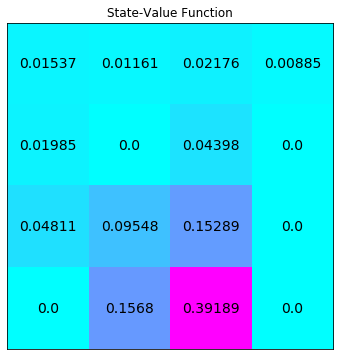

In [20]:
rand_agent = MyRandomAgent(env)
V= policy_MC_evaluation(env, rand_agent)
plot_values_lake(V)

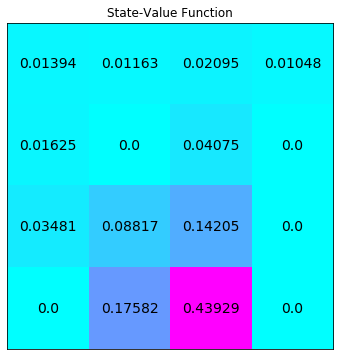

In [21]:
# In reality, here we know the model, we use it to control our results
rand_agent = MyRandomAgent(env)
V = policy_evaluation(env, rand_agent.policy) #see II) dynamic-programming
plot_values_lake(V)

In [22]:
V.sum()

0.9941411498416601

In the same way, we estimate the Q function. 

For Q evaluation
\begin{aligned}
Q(A_t, S_t) &\leftarrow Q(A_t, S_t) + \frac{1}{N_{\text{total}}(A_t, S_t)}(G_t - N_{\text{trajectory}}(A_t, S_t)Q(A_t, S_t))\\
\end{aligned}

And we train an agent, improving its policy by acting greddy.
$\forall s$ $\pi'(.|s) = \arg\max_a Q_\pi(s,a)$.

## Simplest exploration
Without knowing the model, we improve the policy by interacting with the environment. We start with an arbitrary policy, a major problem is caused by a local maximum due to insufficient exploration. To avoid it, we force the agent to act sometimes in a random way (control by an epsilon).

In [19]:
def get_epsilon_greedy_policy(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [20]:
class MyMCAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n])
        self.count_state_actions = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.episode = []
    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward])) # collect trajectories
        self.count_state_actions[current_state, action] += 1
        self.count_state_actions_by_update[current_state, action] += 1
        if done is True: # we train the agent at every end of episode
            episode = np.asarray(self.episode)
            discount_empirical_return = discount_cumsum(episode[:,2], self.gamma)
            for state in range(len(self.count_state_actions)): # evaluate Q
                for action, count in enumerate(self.count_state_actions[state]):
                    if count > 0 :
                        self.q[state,action] += (discount_empirical_return[(episode[:,0] == state) & (episode[:,1] == action)].sum() - self.count_state_actions_by_update[state, action] * self.q[state,action]) / count
            self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
            self.episode = []
            for state in range(env.observation_space.n): # get policy from Q
                self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 367 - cum reward 0.0
episode: 368 - cum reward 0.0
episode: 369 - cum reward 0.0
episode: 370 - cum reward 0.0
episode: 371 - cum reward 0.0
episode: 372 - cum reward 0.0
episode: 373 - cum reward 0.0
episode: 374 - cum reward 0.0
episode: 375 - cum reward 0.0
episode: 376 - cum reward 0.0
episode: 377 - cum reward 0.0
episode: 378 - cum reward 0.0
episode: 379 - cum reward 0.0
episode: 380 - cum reward 0.0
episode: 381 - cum reward 0.0
episode: 382 - cum reward 0.0
episode: 383 - cum reward 0.0
episode: 384 - cum reward 0.0
episode: 385 - cum reward 0.0
episode: 386 - cum reward 0.0
episode: 387 - cum reward 0.0
episode: 388 - cum reward 0.0
episode: 389 - cum reward 0.0
episode: 390 - cum reward 0.0
episode: 391 - cum reward 0.0
episode: 392 - cum reward 0.0
episode: 393 - cum reward 0.0
episode: 394 - cum reward 0.0
episode: 395 - cum reward 0.0
episode: 396 - cum reward 0.0
episode: 397 - cum reward 0.0
episode: 398 - cum reward 0.0
episode: 399 - cum reward 0.0
episode: 4

episode: 728 - cum reward 0.0
episode: 729 - cum reward 0.0
episode: 730 - cum reward 0.0
episode: 731 - cum reward 1.0
episode: 732 - cum reward 0.0
episode: 733 - cum reward 0.0
episode: 734 - cum reward 0.0
episode: 735 - cum reward 0.0
episode: 736 - cum reward 0.0
episode: 737 - cum reward 0.0
episode: 738 - cum reward 0.0
episode: 739 - cum reward 0.0
episode: 740 - cum reward 0.0
episode: 741 - cum reward 0.0
episode: 742 - cum reward 0.0
episode: 743 - cum reward 0.0
episode: 744 - cum reward 0.0
episode: 745 - cum reward 0.0
episode: 746 - cum reward 0.0
episode: 747 - cum reward 0.0
episode: 748 - cum reward 0.0
episode: 749 - cum reward 0.0
episode: 750 - cum reward 0.0
episode: 751 - cum reward 0.0
episode: 752 - cum reward 0.0
episode: 753 - cum reward 0.0
episode: 754 - cum reward 0.0
episode: 755 - cum reward 0.0
episode: 756 - cum reward 0.0
episode: 757 - cum reward 0.0
episode: 758 - cum reward 0.0
episode: 759 - cum reward 0.0
episode: 760 - cum reward 0.0
episode: 7

episode: 1081 - cum reward 0.0
episode: 1082 - cum reward 1.0
episode: 1083 - cum reward 0.0
episode: 1084 - cum reward 0.0
episode: 1085 - cum reward 0.0
episode: 1086 - cum reward 0.0
episode: 1087 - cum reward 0.0
episode: 1088 - cum reward 0.0
episode: 1089 - cum reward 1.0
episode: 1090 - cum reward 0.0
episode: 1091 - cum reward 0.0
episode: 1092 - cum reward 0.0
episode: 1093 - cum reward 0.0
episode: 1094 - cum reward 0.0
episode: 1095 - cum reward 0.0
episode: 1096 - cum reward 0.0
episode: 1097 - cum reward 1.0
episode: 1098 - cum reward 0.0
episode: 1099 - cum reward 0.0
episode: 1100 - cum reward 0.0
episode: 1101 - cum reward 0.0
episode: 1102 - cum reward 0.0
episode: 1103 - cum reward 0.0
episode: 1104 - cum reward 0.0
episode: 1105 - cum reward 0.0
episode: 1106 - cum reward 0.0
episode: 1107 - cum reward 0.0
episode: 1108 - cum reward 0.0
episode: 1109 - cum reward 0.0
episode: 1110 - cum reward 0.0
episode: 1111 - cum reward 0.0
episode: 1112 - cum reward 0.0
episode:

episode: 1445 - cum reward 0.0
episode: 1446 - cum reward 0.0
episode: 1447 - cum reward 0.0
episode: 1448 - cum reward 0.0
episode: 1449 - cum reward 0.0
episode: 1450 - cum reward 0.0
episode: 1451 - cum reward 0.0
episode: 1452 - cum reward 0.0
episode: 1453 - cum reward 0.0
episode: 1454 - cum reward 0.0
episode: 1455 - cum reward 0.0
episode: 1456 - cum reward 0.0
episode: 1457 - cum reward 0.0
episode: 1458 - cum reward 0.0
episode: 1459 - cum reward 0.0
episode: 1460 - cum reward 0.0
episode: 1461 - cum reward 0.0
episode: 1462 - cum reward 0.0
episode: 1463 - cum reward 0.0
episode: 1464 - cum reward 0.0
episode: 1465 - cum reward 0.0
episode: 1466 - cum reward 0.0
episode: 1467 - cum reward 0.0
episode: 1468 - cum reward 0.0
episode: 1469 - cum reward 0.0
episode: 1470 - cum reward 0.0
episode: 1471 - cum reward 0.0
episode: 1472 - cum reward 0.0
episode: 1473 - cum reward 0.0
episode: 1474 - cum reward 0.0
episode: 1475 - cum reward 0.0
episode: 1476 - cum reward 0.0
episode:

episode: 1812 - cum reward 0.0
episode: 1813 - cum reward 0.0
episode: 1814 - cum reward 0.0
episode: 1815 - cum reward 0.0
episode: 1816 - cum reward 0.0
episode: 1817 - cum reward 0.0
episode: 1818 - cum reward 0.0
episode: 1819 - cum reward 0.0
episode: 1820 - cum reward 0.0
episode: 1821 - cum reward 0.0
episode: 1822 - cum reward 0.0
episode: 1823 - cum reward 0.0
episode: 1824 - cum reward 0.0
episode: 1825 - cum reward 0.0
episode: 1826 - cum reward 0.0
episode: 1827 - cum reward 0.0
episode: 1828 - cum reward 1.0
episode: 1829 - cum reward 0.0
episode: 1830 - cum reward 0.0
episode: 1831 - cum reward 0.0
episode: 1832 - cum reward 0.0
episode: 1833 - cum reward 0.0
episode: 1834 - cum reward 0.0
episode: 1835 - cum reward 0.0
episode: 1836 - cum reward 0.0
episode: 1837 - cum reward 0.0
episode: 1838 - cum reward 0.0
episode: 1839 - cum reward 0.0
episode: 1840 - cum reward 0.0
episode: 1841 - cum reward 0.0
episode: 1842 - cum reward 0.0
episode: 1843 - cum reward 0.0
episode:

episode: 2170 - cum reward 0.0
episode: 2171 - cum reward 0.0
episode: 2172 - cum reward 0.0
episode: 2173 - cum reward 0.0
episode: 2174 - cum reward 0.0
episode: 2175 - cum reward 0.0
episode: 2176 - cum reward 1.0
episode: 2177 - cum reward 0.0
episode: 2178 - cum reward 0.0
episode: 2179 - cum reward 0.0
episode: 2180 - cum reward 0.0
episode: 2181 - cum reward 0.0
episode: 2182 - cum reward 0.0
episode: 2183 - cum reward 0.0
episode: 2184 - cum reward 0.0
episode: 2185 - cum reward 0.0
episode: 2186 - cum reward 0.0
episode: 2187 - cum reward 0.0
episode: 2188 - cum reward 0.0
episode: 2189 - cum reward 0.0
episode: 2190 - cum reward 0.0
episode: 2191 - cum reward 0.0
episode: 2192 - cum reward 0.0
episode: 2193 - cum reward 0.0
episode: 2194 - cum reward 0.0
episode: 2195 - cum reward 0.0
episode: 2196 - cum reward 0.0
episode: 2197 - cum reward 0.0
episode: 2198 - cum reward 0.0
episode: 2199 - cum reward 0.0
episode: 2200 - cum reward 0.0
episode: 2201 - cum reward 0.0
episode:

episode: 2533 - cum reward 0.0
episode: 2534 - cum reward 0.0
episode: 2535 - cum reward 0.0
episode: 2536 - cum reward 0.0
episode: 2537 - cum reward 0.0
episode: 2538 - cum reward 0.0
episode: 2539 - cum reward 0.0
episode: 2540 - cum reward 1.0
episode: 2541 - cum reward 0.0
episode: 2542 - cum reward 0.0
episode: 2543 - cum reward 0.0
episode: 2544 - cum reward 0.0
episode: 2545 - cum reward 0.0
episode: 2546 - cum reward 0.0
episode: 2547 - cum reward 0.0
episode: 2548 - cum reward 0.0
episode: 2549 - cum reward 0.0
episode: 2550 - cum reward 0.0
episode: 2551 - cum reward 0.0
episode: 2552 - cum reward 0.0
episode: 2553 - cum reward 0.0
episode: 2554 - cum reward 0.0
episode: 2555 - cum reward 0.0
episode: 2556 - cum reward 1.0
episode: 2557 - cum reward 0.0
episode: 2558 - cum reward 0.0
episode: 2559 - cum reward 0.0
episode: 2560 - cum reward 0.0
episode: 2561 - cum reward 0.0
episode: 2562 - cum reward 0.0
episode: 2563 - cum reward 0.0
episode: 2564 - cum reward 0.0
episode:

episode: 2895 - cum reward 0.0
episode: 2896 - cum reward 0.0
episode: 2897 - cum reward 1.0
episode: 2898 - cum reward 0.0
episode: 2899 - cum reward 1.0
episode: 2900 - cum reward 0.0
episode: 2901 - cum reward 0.0
episode: 2902 - cum reward 0.0
episode: 2903 - cum reward 0.0
episode: 2904 - cum reward 0.0
episode: 2905 - cum reward 0.0
episode: 2906 - cum reward 1.0
episode: 2907 - cum reward 0.0
episode: 2908 - cum reward 0.0
episode: 2909 - cum reward 0.0
episode: 2910 - cum reward 1.0
episode: 2911 - cum reward 0.0
episode: 2912 - cum reward 0.0
episode: 2913 - cum reward 0.0
episode: 2914 - cum reward 0.0
episode: 2915 - cum reward 0.0
episode: 2916 - cum reward 0.0
episode: 2917 - cum reward 0.0
episode: 2918 - cum reward 0.0
episode: 2919 - cum reward 1.0
episode: 2920 - cum reward 0.0
episode: 2921 - cum reward 0.0
episode: 2922 - cum reward 0.0
episode: 2923 - cum reward 0.0
episode: 2924 - cum reward 0.0
episode: 2925 - cum reward 0.0
episode: 2926 - cum reward 0.0
episode:

episode: 3255 - cum reward 0.0
episode: 3256 - cum reward 0.0
episode: 3257 - cum reward 0.0
episode: 3258 - cum reward 0.0
episode: 3259 - cum reward 0.0
episode: 3260 - cum reward 0.0
episode: 3261 - cum reward 0.0
episode: 3262 - cum reward 0.0
episode: 3263 - cum reward 0.0
episode: 3264 - cum reward 0.0
episode: 3265 - cum reward 0.0
episode: 3266 - cum reward 0.0
episode: 3267 - cum reward 0.0
episode: 3268 - cum reward 0.0
episode: 3269 - cum reward 0.0
episode: 3270 - cum reward 0.0
episode: 3271 - cum reward 0.0
episode: 3272 - cum reward 0.0
episode: 3273 - cum reward 0.0
episode: 3274 - cum reward 0.0
episode: 3275 - cum reward 0.0
episode: 3276 - cum reward 0.0
episode: 3277 - cum reward 0.0
episode: 3278 - cum reward 0.0
episode: 3279 - cum reward 0.0
episode: 3280 - cum reward 1.0
episode: 3281 - cum reward 0.0
episode: 3282 - cum reward 0.0
episode: 3283 - cum reward 0.0
episode: 3284 - cum reward 0.0
episode: 3285 - cum reward 0.0
episode: 3286 - cum reward 0.0
episode:

episode: 3612 - cum reward 0.0
episode: 3613 - cum reward 0.0
episode: 3614 - cum reward 0.0
episode: 3615 - cum reward 0.0
episode: 3616 - cum reward 0.0
episode: 3617 - cum reward 0.0
episode: 3618 - cum reward 0.0
episode: 3619 - cum reward 0.0
episode: 3620 - cum reward 0.0
episode: 3621 - cum reward 0.0
episode: 3622 - cum reward 0.0
episode: 3623 - cum reward 0.0
episode: 3624 - cum reward 0.0
episode: 3625 - cum reward 0.0
episode: 3626 - cum reward 0.0
episode: 3627 - cum reward 0.0
episode: 3628 - cum reward 0.0
episode: 3629 - cum reward 0.0
episode: 3630 - cum reward 0.0
episode: 3631 - cum reward 0.0
episode: 3632 - cum reward 1.0
episode: 3633 - cum reward 0.0
episode: 3634 - cum reward 0.0
episode: 3635 - cum reward 0.0
episode: 3636 - cum reward 0.0
episode: 3637 - cum reward 0.0
episode: 3638 - cum reward 0.0
episode: 3639 - cum reward 0.0
episode: 3640 - cum reward 0.0
episode: 3641 - cum reward 0.0
episode: 3642 - cum reward 0.0
episode: 3643 - cum reward 0.0
episode:

episode: 3961 - cum reward 0.0
episode: 3962 - cum reward 0.0
episode: 3963 - cum reward 0.0
episode: 3964 - cum reward 0.0
episode: 3965 - cum reward 0.0
episode: 3966 - cum reward 0.0
episode: 3967 - cum reward 0.0
episode: 3968 - cum reward 0.0
episode: 3969 - cum reward 0.0
episode: 3970 - cum reward 1.0
episode: 3971 - cum reward 0.0
episode: 3972 - cum reward 0.0
episode: 3973 - cum reward 0.0
episode: 3974 - cum reward 0.0
episode: 3975 - cum reward 0.0
episode: 3976 - cum reward 0.0
episode: 3977 - cum reward 0.0
episode: 3978 - cum reward 0.0
episode: 3979 - cum reward 0.0
episode: 3980 - cum reward 0.0
episode: 3981 - cum reward 1.0
episode: 3982 - cum reward 0.0
episode: 3983 - cum reward 0.0
episode: 3984 - cum reward 0.0
episode: 3985 - cum reward 0.0
episode: 3986 - cum reward 0.0
episode: 3987 - cum reward 0.0
episode: 3988 - cum reward 0.0
episode: 3989 - cum reward 0.0
episode: 3990 - cum reward 0.0
episode: 3991 - cum reward 0.0
episode: 3992 - cum reward 0.0
episode:

episode: 4329 - cum reward 0.0
episode: 4330 - cum reward 0.0
episode: 4331 - cum reward 0.0
episode: 4332 - cum reward 0.0
episode: 4333 - cum reward 0.0
episode: 4334 - cum reward 0.0
episode: 4335 - cum reward 0.0
episode: 4336 - cum reward 0.0
episode: 4337 - cum reward 0.0
episode: 4338 - cum reward 0.0
episode: 4339 - cum reward 0.0
episode: 4340 - cum reward 0.0
episode: 4341 - cum reward 0.0
episode: 4342 - cum reward 0.0
episode: 4343 - cum reward 0.0
episode: 4344 - cum reward 0.0
episode: 4345 - cum reward 0.0
episode: 4346 - cum reward 0.0
episode: 4347 - cum reward 0.0
episode: 4348 - cum reward 0.0
episode: 4349 - cum reward 0.0
episode: 4350 - cum reward 0.0
episode: 4351 - cum reward 0.0
episode: 4352 - cum reward 0.0
episode: 4353 - cum reward 0.0
episode: 4354 - cum reward 0.0
episode: 4355 - cum reward 0.0
episode: 4356 - cum reward 0.0
episode: 4357 - cum reward 0.0
episode: 4358 - cum reward 0.0
episode: 4359 - cum reward 0.0
episode: 4360 - cum reward 0.0
episode:

episode: 4664 - cum reward 0.0
episode: 4665 - cum reward 0.0
episode: 4666 - cum reward 1.0
episode: 4667 - cum reward 1.0
episode: 4668 - cum reward 0.0
episode: 4669 - cum reward 0.0
episode: 4670 - cum reward 0.0
episode: 4671 - cum reward 0.0
episode: 4672 - cum reward 0.0
episode: 4673 - cum reward 0.0
episode: 4674 - cum reward 0.0
episode: 4675 - cum reward 1.0
episode: 4676 - cum reward 0.0
episode: 4677 - cum reward 0.0
episode: 4678 - cum reward 0.0
episode: 4679 - cum reward 0.0
episode: 4680 - cum reward 0.0
episode: 4681 - cum reward 0.0
episode: 4682 - cum reward 0.0
episode: 4683 - cum reward 0.0
episode: 4684 - cum reward 0.0
episode: 4685 - cum reward 0.0
episode: 4686 - cum reward 0.0
episode: 4687 - cum reward 0.0
episode: 4688 - cum reward 0.0
episode: 4689 - cum reward 0.0
episode: 4690 - cum reward 0.0
episode: 4691 - cum reward 0.0
episode: 4692 - cum reward 1.0
episode: 4693 - cum reward 0.0
episode: 4694 - cum reward 0.0
episode: 4695 - cum reward 0.0
episode:

episode: 4967 - cum reward 0.0
episode: 4968 - cum reward 0.0
episode: 4969 - cum reward 0.0
episode: 4970 - cum reward 0.0
episode: 4971 - cum reward 0.0
episode: 4972 - cum reward 0.0
episode: 4973 - cum reward 0.0
episode: 4974 - cum reward 0.0
episode: 4975 - cum reward 0.0
episode: 4976 - cum reward 0.0
episode: 4977 - cum reward 0.0
episode: 4978 - cum reward 0.0
episode: 4979 - cum reward 0.0
episode: 4980 - cum reward 0.0
episode: 4981 - cum reward 0.0
episode: 4982 - cum reward 0.0
episode: 4983 - cum reward 0.0
episode: 4984 - cum reward 0.0
episode: 4985 - cum reward 0.0
episode: 4986 - cum reward 0.0
episode: 4987 - cum reward 0.0
episode: 4988 - cum reward 0.0
episode: 4989 - cum reward 0.0
episode: 4990 - cum reward 0.0
episode: 4991 - cum reward 1.0
episode: 4992 - cum reward 0.0
episode: 4993 - cum reward 0.0
episode: 4994 - cum reward 0.0
episode: 4995 - cum reward 0.0
episode: 4996 - cum reward 0.0
episode: 4997 - cum reward 0.0
episode: 4998 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - mc_agent')

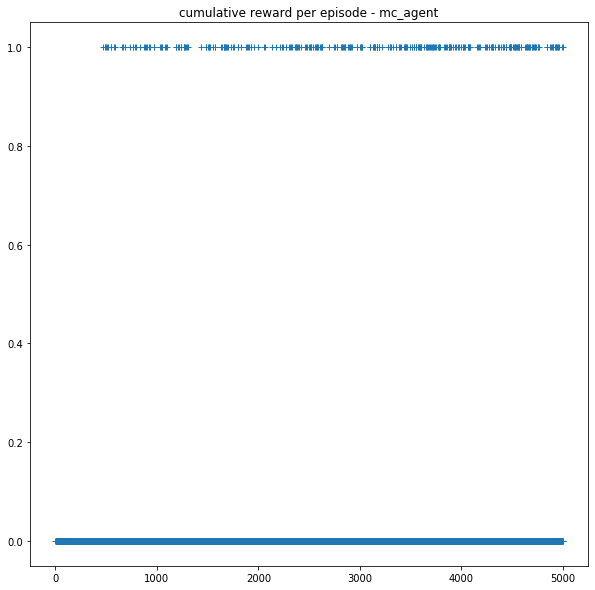

In [33]:
mc_agent = MyMCAgent(env)
rewards = run_experiment_episode_train(env, mc_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - mc_agent')

In [34]:
mc_agent.policy

array([[0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

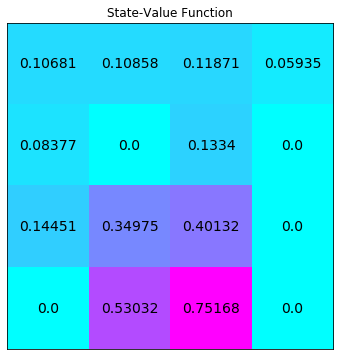

In [35]:
V = policy_evaluation(env, mc_agent.policy)
plot_values_lake(V)

In [36]:
V.sum()

2.7881895433321127

# Temporal-Difference-Learning (Monte-Carlo bootstrap) 

Using monte-carlo, we update $V(S_t)$ in that way

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_t)) \\
\end{aligned}
We also know (bellman equation) $\mathbb{E}[G_t|S_t=s] = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})|S_t=s]$. That pushes new estimators/update

TD target $= R_{t+1} + \gamma V(S_{t+1}$)

TD error $=$ target $- V(S_t)$

update:  

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}

In [37]:
#TODO: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += None #complete here
    return V

In [38]:
#Done: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += td_error * alpha
    return V

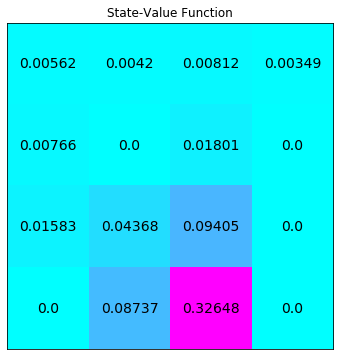

In [39]:
rand_agent = MyRandomAgent(env)
V = policy_td_evaluation(env, rand_agent)
plot_values_lake(V)

### SARSA

Same principle for q function update using Temporal difference$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$.

In [40]:
class MySarsaAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.sarsa = [None, None, None, None, None] #[s,a,r,s,a]
        self.tmp_reward = None
    def qsa_update(self, done):
        if done:
            target = self.sarsa[2]
        else:
            target = self.sarsa[2] + self.gamma * self.q[self.sarsa[-2], self.sarsa[-1]] 
        td_error = target - self.q[self.sarsa[0], self.sarsa[1]]
        self.q[self.sarsa[0], self.sarsa[1]]  += self.alpha * td_error
        
    def train(self, current_state, action, reward, next_state, done):
        self.sarsa[0] = self.sarsa[-2]
        self.sarsa[1] = self.sarsa[-1]
        self.sarsa[2] = self.tmp_reward
        self.sarsa[3] = current_state
        self.sarsa[4] = action
        self.tmp_reward = reward
        if self.sarsa[0] is None:
            pass
        else:
            self.qsa_update(done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 1.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 284 - cum reward 1.0
episode: 285 - cum reward 0.0
episode: 286 - cum reward 0.0
episode: 287 - cum reward 0.0
episode: 288 - cum reward 0.0
episode: 289 - cum reward 1.0
episode: 290 - cum reward 0.0
episode: 291 - cum reward 0.0
episode: 292 - cum reward 0.0
episode: 293 - cum reward 0.0
episode: 294 - cum reward 0.0
episode: 295 - cum reward 0.0
episode: 296 - cum reward 0.0
episode: 297 - cum reward 0.0
episode: 298 - cum reward 0.0
episode: 299 - cum reward 0.0
episode: 300 - cum reward 0.0
episode: 301 - cum reward 0.0
episode: 302 - cum reward 0.0
episode: 303 - cum reward 0.0
episode: 304 - cum reward 0.0
episode: 305 - cum reward 0.0
episode: 306 - cum reward 0.0
episode: 307 - cum reward 0.0
episode: 308 - cum reward 0.0
episode: 309 - cum reward 0.0
episode: 310 - cum reward 0.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 0.0
episode: 314 - cum reward 0.0
episode: 315 - cum reward 0.0
episode: 316 - cum reward 0.0
episode: 3

episode: 609 - cum reward 0.0
episode: 610 - cum reward 0.0
episode: 611 - cum reward 0.0
episode: 612 - cum reward 0.0
episode: 613 - cum reward 0.0
episode: 614 - cum reward 0.0
episode: 615 - cum reward 0.0
episode: 616 - cum reward 0.0
episode: 617 - cum reward 0.0
episode: 618 - cum reward 0.0
episode: 619 - cum reward 0.0
episode: 620 - cum reward 0.0
episode: 621 - cum reward 0.0
episode: 622 - cum reward 0.0
episode: 623 - cum reward 0.0
episode: 624 - cum reward 0.0
episode: 625 - cum reward 0.0
episode: 626 - cum reward 0.0
episode: 627 - cum reward 0.0
episode: 628 - cum reward 0.0
episode: 629 - cum reward 0.0
episode: 630 - cum reward 0.0
episode: 631 - cum reward 0.0
episode: 632 - cum reward 0.0
episode: 633 - cum reward 0.0
episode: 634 - cum reward 0.0
episode: 635 - cum reward 0.0
episode: 636 - cum reward 0.0
episode: 637 - cum reward 0.0
episode: 638 - cum reward 0.0
episode: 639 - cum reward 0.0
episode: 640 - cum reward 0.0
episode: 641 - cum reward 0.0
episode: 6

episode: 969 - cum reward 0.0
episode: 970 - cum reward 0.0
episode: 971 - cum reward 0.0
episode: 972 - cum reward 0.0
episode: 973 - cum reward 0.0
episode: 974 - cum reward 0.0
episode: 975 - cum reward 0.0
episode: 976 - cum reward 0.0
episode: 977 - cum reward 0.0
episode: 978 - cum reward 0.0
episode: 979 - cum reward 0.0
episode: 980 - cum reward 0.0
episode: 981 - cum reward 0.0
episode: 982 - cum reward 0.0
episode: 983 - cum reward 0.0
episode: 984 - cum reward 0.0
episode: 985 - cum reward 0.0
episode: 986 - cum reward 0.0
episode: 987 - cum reward 0.0
episode: 988 - cum reward 0.0
episode: 989 - cum reward 0.0
episode: 990 - cum reward 0.0
episode: 991 - cum reward 0.0
episode: 992 - cum reward 0.0
episode: 993 - cum reward 0.0
episode: 994 - cum reward 0.0
episode: 995 - cum reward 0.0
episode: 996 - cum reward 0.0
episode: 997 - cum reward 0.0
episode: 998 - cum reward 0.0
episode: 999 - cum reward 0.0
episode: 1000 - cum reward 0.0
episode: 1001 - cum reward 0.0
episode:

episode: 1241 - cum reward 0.0
episode: 1242 - cum reward 0.0
episode: 1243 - cum reward 1.0
episode: 1244 - cum reward 0.0
episode: 1245 - cum reward 0.0
episode: 1246 - cum reward 0.0
episode: 1247 - cum reward 0.0
episode: 1248 - cum reward 0.0
episode: 1249 - cum reward 0.0
episode: 1250 - cum reward 0.0
episode: 1251 - cum reward 0.0
episode: 1252 - cum reward 0.0
episode: 1253 - cum reward 0.0
episode: 1254 - cum reward 0.0
episode: 1255 - cum reward 0.0
episode: 1256 - cum reward 0.0
episode: 1257 - cum reward 0.0
episode: 1258 - cum reward 0.0
episode: 1259 - cum reward 0.0
episode: 1260 - cum reward 0.0
episode: 1261 - cum reward 0.0
episode: 1262 - cum reward 0.0
episode: 1263 - cum reward 0.0
episode: 1264 - cum reward 0.0
episode: 1265 - cum reward 0.0
episode: 1266 - cum reward 0.0
episode: 1267 - cum reward 0.0
episode: 1268 - cum reward 0.0
episode: 1269 - cum reward 0.0
episode: 1270 - cum reward 0.0
episode: 1271 - cum reward 0.0
episode: 1272 - cum reward 0.0
episode:

episode: 1575 - cum reward 0.0
episode: 1576 - cum reward 0.0
episode: 1577 - cum reward 0.0
episode: 1578 - cum reward 0.0
episode: 1579 - cum reward 0.0
episode: 1580 - cum reward 0.0
episode: 1581 - cum reward 0.0
episode: 1582 - cum reward 0.0
episode: 1583 - cum reward 0.0
episode: 1584 - cum reward 0.0
episode: 1585 - cum reward 0.0
episode: 1586 - cum reward 0.0
episode: 1587 - cum reward 0.0
episode: 1588 - cum reward 0.0
episode: 1589 - cum reward 0.0
episode: 1590 - cum reward 0.0
episode: 1591 - cum reward 0.0
episode: 1592 - cum reward 0.0
episode: 1593 - cum reward 0.0
episode: 1594 - cum reward 0.0
episode: 1595 - cum reward 0.0
episode: 1596 - cum reward 0.0
episode: 1597 - cum reward 0.0
episode: 1598 - cum reward 0.0
episode: 1599 - cum reward 0.0
episode: 1600 - cum reward 0.0
episode: 1601 - cum reward 0.0
episode: 1602 - cum reward 0.0
episode: 1603 - cum reward 0.0
episode: 1604 - cum reward 0.0
episode: 1605 - cum reward 0.0
episode: 1606 - cum reward 0.0
episode:

episode: 1890 - cum reward 0.0
episode: 1891 - cum reward 0.0
episode: 1892 - cum reward 0.0
episode: 1893 - cum reward 0.0
episode: 1894 - cum reward 0.0
episode: 1895 - cum reward 0.0
episode: 1896 - cum reward 0.0
episode: 1897 - cum reward 0.0
episode: 1898 - cum reward 0.0
episode: 1899 - cum reward 0.0
episode: 1900 - cum reward 0.0
episode: 1901 - cum reward 0.0
episode: 1902 - cum reward 0.0
episode: 1903 - cum reward 0.0
episode: 1904 - cum reward 0.0
episode: 1905 - cum reward 0.0
episode: 1906 - cum reward 0.0
episode: 1907 - cum reward 0.0
episode: 1908 - cum reward 0.0
episode: 1909 - cum reward 0.0
episode: 1910 - cum reward 0.0
episode: 1911 - cum reward 0.0
episode: 1912 - cum reward 0.0
episode: 1913 - cum reward 0.0
episode: 1914 - cum reward 0.0
episode: 1915 - cum reward 0.0
episode: 1916 - cum reward 0.0
episode: 1917 - cum reward 0.0
episode: 1918 - cum reward 0.0
episode: 1919 - cum reward 0.0
episode: 1920 - cum reward 0.0
episode: 1921 - cum reward 0.0
episode:

episode: 2219 - cum reward 1.0
episode: 2220 - cum reward 0.0
episode: 2221 - cum reward 0.0
episode: 2222 - cum reward 0.0
episode: 2223 - cum reward 0.0
episode: 2224 - cum reward 0.0
episode: 2225 - cum reward 0.0
episode: 2226 - cum reward 0.0
episode: 2227 - cum reward 0.0
episode: 2228 - cum reward 0.0
episode: 2229 - cum reward 0.0
episode: 2230 - cum reward 0.0
episode: 2231 - cum reward 0.0
episode: 2232 - cum reward 0.0
episode: 2233 - cum reward 0.0
episode: 2234 - cum reward 0.0
episode: 2235 - cum reward 0.0
episode: 2236 - cum reward 0.0
episode: 2237 - cum reward 0.0
episode: 2238 - cum reward 0.0
episode: 2239 - cum reward 0.0
episode: 2240 - cum reward 0.0
episode: 2241 - cum reward 0.0
episode: 2242 - cum reward 0.0
episode: 2243 - cum reward 0.0
episode: 2244 - cum reward 0.0
episode: 2245 - cum reward 0.0
episode: 2246 - cum reward 0.0
episode: 2247 - cum reward 0.0
episode: 2248 - cum reward 0.0
episode: 2249 - cum reward 0.0
episode: 2250 - cum reward 0.0
episode:

episode: 2514 - cum reward 0.0
episode: 2515 - cum reward 0.0
episode: 2516 - cum reward 0.0
episode: 2517 - cum reward 0.0
episode: 2518 - cum reward 0.0
episode: 2519 - cum reward 0.0
episode: 2520 - cum reward 0.0
episode: 2521 - cum reward 0.0
episode: 2522 - cum reward 0.0
episode: 2523 - cum reward 0.0
episode: 2524 - cum reward 0.0
episode: 2525 - cum reward 0.0
episode: 2526 - cum reward 0.0
episode: 2527 - cum reward 0.0
episode: 2528 - cum reward 0.0
episode: 2529 - cum reward 0.0
episode: 2530 - cum reward 0.0
episode: 2531 - cum reward 0.0
episode: 2532 - cum reward 0.0
episode: 2533 - cum reward 1.0
episode: 2534 - cum reward 0.0
episode: 2535 - cum reward 0.0
episode: 2536 - cum reward 0.0
episode: 2537 - cum reward 0.0
episode: 2538 - cum reward 0.0
episode: 2539 - cum reward 0.0
episode: 2540 - cum reward 0.0
episode: 2541 - cum reward 0.0
episode: 2542 - cum reward 0.0
episode: 2543 - cum reward 0.0
episode: 2544 - cum reward 0.0
episode: 2545 - cum reward 0.0
episode:

episode: 2830 - cum reward 0.0
episode: 2831 - cum reward 0.0
episode: 2832 - cum reward 0.0
episode: 2833 - cum reward 0.0
episode: 2834 - cum reward 0.0
episode: 2835 - cum reward 0.0
episode: 2836 - cum reward 0.0
episode: 2837 - cum reward 0.0
episode: 2838 - cum reward 0.0
episode: 2839 - cum reward 0.0
episode: 2840 - cum reward 0.0
episode: 2841 - cum reward 0.0
episode: 2842 - cum reward 0.0
episode: 2843 - cum reward 0.0
episode: 2844 - cum reward 0.0
episode: 2845 - cum reward 0.0
episode: 2846 - cum reward 0.0
episode: 2847 - cum reward 0.0
episode: 2848 - cum reward 0.0
episode: 2849 - cum reward 0.0
episode: 2850 - cum reward 0.0
episode: 2851 - cum reward 0.0
episode: 2852 - cum reward 0.0
episode: 2853 - cum reward 0.0
episode: 2854 - cum reward 0.0
episode: 2855 - cum reward 0.0
episode: 2856 - cum reward 0.0
episode: 2857 - cum reward 0.0
episode: 2858 - cum reward 0.0
episode: 2859 - cum reward 0.0
episode: 2860 - cum reward 0.0
episode: 2861 - cum reward 0.0
episode:

episode: 3146 - cum reward 0.0
episode: 3147 - cum reward 0.0
episode: 3148 - cum reward 0.0
episode: 3149 - cum reward 0.0
episode: 3150 - cum reward 0.0
episode: 3151 - cum reward 0.0
episode: 3152 - cum reward 0.0
episode: 3153 - cum reward 0.0
episode: 3154 - cum reward 0.0
episode: 3155 - cum reward 0.0
episode: 3156 - cum reward 0.0
episode: 3157 - cum reward 0.0
episode: 3158 - cum reward 0.0
episode: 3159 - cum reward 0.0
episode: 3160 - cum reward 0.0
episode: 3161 - cum reward 0.0
episode: 3162 - cum reward 0.0
episode: 3163 - cum reward 0.0
episode: 3164 - cum reward 0.0
episode: 3165 - cum reward 0.0
episode: 3166 - cum reward 0.0
episode: 3167 - cum reward 0.0
episode: 3168 - cum reward 0.0
episode: 3169 - cum reward 0.0
episode: 3170 - cum reward 0.0
episode: 3171 - cum reward 0.0
episode: 3172 - cum reward 0.0
episode: 3173 - cum reward 0.0
episode: 3174 - cum reward 0.0
episode: 3175 - cum reward 0.0
episode: 3176 - cum reward 0.0
episode: 3177 - cum reward 0.0
episode:

episode: 3490 - cum reward 0.0
episode: 3491 - cum reward 0.0
episode: 3492 - cum reward 0.0
episode: 3493 - cum reward 0.0
episode: 3494 - cum reward 0.0
episode: 3495 - cum reward 0.0
episode: 3496 - cum reward 0.0
episode: 3497 - cum reward 0.0
episode: 3498 - cum reward 0.0
episode: 3499 - cum reward 0.0
episode: 3500 - cum reward 0.0
episode: 3501 - cum reward 0.0
episode: 3502 - cum reward 0.0
episode: 3503 - cum reward 0.0
episode: 3504 - cum reward 0.0
episode: 3505 - cum reward 0.0
episode: 3506 - cum reward 0.0
episode: 3507 - cum reward 0.0
episode: 3508 - cum reward 0.0
episode: 3509 - cum reward 0.0
episode: 3510 - cum reward 0.0
episode: 3511 - cum reward 0.0
episode: 3512 - cum reward 0.0
episode: 3513 - cum reward 0.0
episode: 3514 - cum reward 0.0
episode: 3515 - cum reward 0.0
episode: 3516 - cum reward 1.0
episode: 3517 - cum reward 0.0
episode: 3518 - cum reward 0.0
episode: 3519 - cum reward 0.0
episode: 3520 - cum reward 0.0
episode: 3521 - cum reward 0.0
episode:

episode: 3759 - cum reward 0.0
episode: 3760 - cum reward 0.0
episode: 3761 - cum reward 0.0
episode: 3762 - cum reward 0.0
episode: 3763 - cum reward 0.0
episode: 3764 - cum reward 0.0
episode: 3765 - cum reward 0.0
episode: 3766 - cum reward 1.0
episode: 3767 - cum reward 0.0
episode: 3768 - cum reward 0.0
episode: 3769 - cum reward 0.0
episode: 3770 - cum reward 0.0
episode: 3771 - cum reward 0.0
episode: 3772 - cum reward 0.0
episode: 3773 - cum reward 0.0
episode: 3774 - cum reward 0.0
episode: 3775 - cum reward 0.0
episode: 3776 - cum reward 0.0
episode: 3777 - cum reward 0.0
episode: 3778 - cum reward 0.0
episode: 3779 - cum reward 0.0
episode: 3780 - cum reward 0.0
episode: 3781 - cum reward 0.0
episode: 3782 - cum reward 0.0
episode: 3783 - cum reward 0.0
episode: 3784 - cum reward 0.0
episode: 3785 - cum reward 0.0
episode: 3786 - cum reward 1.0
episode: 3787 - cum reward 0.0
episode: 3788 - cum reward 0.0
episode: 3789 - cum reward 1.0
episode: 3790 - cum reward 0.0
episode:

episode: 4066 - cum reward 0.0
episode: 4067 - cum reward 0.0
episode: 4068 - cum reward 0.0
episode: 4069 - cum reward 0.0
episode: 4070 - cum reward 0.0
episode: 4071 - cum reward 0.0
episode: 4072 - cum reward 0.0
episode: 4073 - cum reward 1.0
episode: 4074 - cum reward 0.0
episode: 4075 - cum reward 0.0
episode: 4076 - cum reward 0.0
episode: 4077 - cum reward 0.0
episode: 4078 - cum reward 0.0
episode: 4079 - cum reward 0.0
episode: 4080 - cum reward 0.0
episode: 4081 - cum reward 0.0
episode: 4082 - cum reward 0.0
episode: 4083 - cum reward 0.0
episode: 4084 - cum reward 0.0
episode: 4085 - cum reward 0.0
episode: 4086 - cum reward 0.0
episode: 4087 - cum reward 0.0
episode: 4088 - cum reward 0.0
episode: 4089 - cum reward 0.0
episode: 4090 - cum reward 0.0
episode: 4091 - cum reward 0.0
episode: 4092 - cum reward 0.0
episode: 4093 - cum reward 0.0
episode: 4094 - cum reward 0.0
episode: 4095 - cum reward 0.0
episode: 4096 - cum reward 0.0
episode: 4097 - cum reward 0.0
episode:

episode: 4404 - cum reward 0.0
episode: 4405 - cum reward 0.0
episode: 4406 - cum reward 0.0
episode: 4407 - cum reward 0.0
episode: 4408 - cum reward 0.0
episode: 4409 - cum reward 0.0
episode: 4410 - cum reward 0.0
episode: 4411 - cum reward 0.0
episode: 4412 - cum reward 0.0
episode: 4413 - cum reward 0.0
episode: 4414 - cum reward 0.0
episode: 4415 - cum reward 0.0
episode: 4416 - cum reward 0.0
episode: 4417 - cum reward 1.0
episode: 4418 - cum reward 0.0
episode: 4419 - cum reward 0.0
episode: 4420 - cum reward 0.0
episode: 4421 - cum reward 0.0
episode: 4422 - cum reward 0.0
episode: 4423 - cum reward 0.0
episode: 4424 - cum reward 0.0
episode: 4425 - cum reward 0.0
episode: 4426 - cum reward 0.0
episode: 4427 - cum reward 1.0
episode: 4428 - cum reward 0.0
episode: 4429 - cum reward 0.0
episode: 4430 - cum reward 0.0
episode: 4431 - cum reward 0.0
episode: 4432 - cum reward 0.0
episode: 4433 - cum reward 0.0
episode: 4434 - cum reward 0.0
episode: 4435 - cum reward 1.0
episode:

episode: 4699 - cum reward 0.0
episode: 4700 - cum reward 0.0
episode: 4701 - cum reward 0.0
episode: 4702 - cum reward 0.0
episode: 4703 - cum reward 0.0
episode: 4704 - cum reward 0.0
episode: 4705 - cum reward 0.0
episode: 4706 - cum reward 0.0
episode: 4707 - cum reward 0.0
episode: 4708 - cum reward 0.0
episode: 4709 - cum reward 0.0
episode: 4710 - cum reward 0.0
episode: 4711 - cum reward 0.0
episode: 4712 - cum reward 0.0
episode: 4713 - cum reward 1.0
episode: 4714 - cum reward 0.0
episode: 4715 - cum reward 0.0
episode: 4716 - cum reward 0.0
episode: 4717 - cum reward 0.0
episode: 4718 - cum reward 0.0
episode: 4719 - cum reward 0.0
episode: 4720 - cum reward 0.0
episode: 4721 - cum reward 0.0
episode: 4722 - cum reward 0.0
episode: 4723 - cum reward 0.0
episode: 4724 - cum reward 0.0
episode: 4725 - cum reward 0.0
episode: 4726 - cum reward 0.0
episode: 4727 - cum reward 0.0
episode: 4728 - cum reward 0.0
episode: 4729 - cum reward 0.0
episode: 4730 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - sarsa_agent')

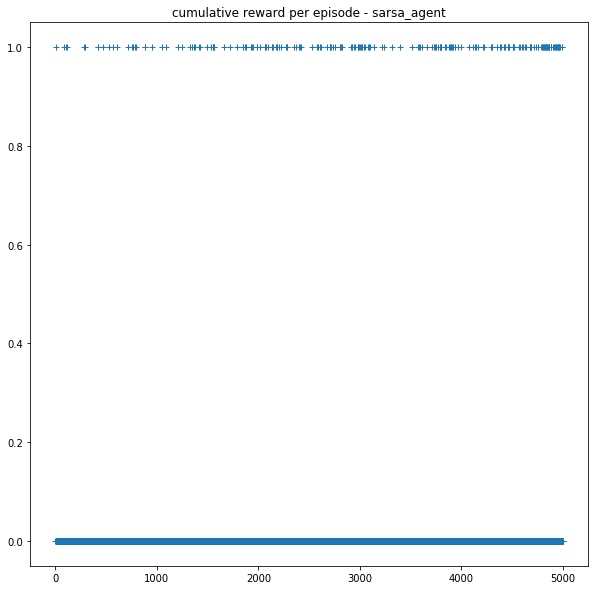

In [48]:
sarsa_agent = MySarsaAgent(env)
rewards = run_experiment_episode_train(env, sarsa_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - sarsa_agent')

In [42]:
sarsa_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

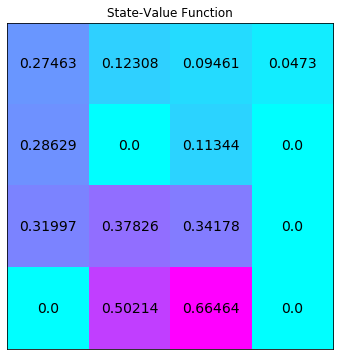

In [43]:
V = policy_evaluation(env, sarsa_agent.policy)
plot_values_lake(V)

In [44]:
V.sum()

3.14615629094904

### Q-learning

Q learning is an offpolicy sarsa. Instead of update the Q function with the current policy action, it uses a greedy estimation of the policy action

SARAS $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$

Q-learning $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

In [45]:
#TODO: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        pass #complete here
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

In [46]:
#Done: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        if done is False:
            target = reward + self.gamma * np.max(self.q[next_state, :])
        else:
            target = reward
        td_error = target - self.q[state, action]
        self.q[state, action]  += self.alpha * td_error
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 1.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 1.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 281 - cum reward 0.0
episode: 282 - cum reward 0.0
episode: 283 - cum reward 0.0
episode: 284 - cum reward 0.0
episode: 285 - cum reward 1.0
episode: 286 - cum reward 0.0
episode: 287 - cum reward 0.0
episode: 288 - cum reward 0.0
episode: 289 - cum reward 1.0
episode: 290 - cum reward 0.0
episode: 291 - cum reward 0.0
episode: 292 - cum reward 0.0
episode: 293 - cum reward 0.0
episode: 294 - cum reward 0.0
episode: 295 - cum reward 0.0
episode: 296 - cum reward 1.0
episode: 297 - cum reward 0.0
episode: 298 - cum reward 0.0
episode: 299 - cum reward 0.0
episode: 300 - cum reward 0.0
episode: 301 - cum reward 0.0
episode: 302 - cum reward 0.0
episode: 303 - cum reward 1.0
episode: 304 - cum reward 1.0
episode: 305 - cum reward 0.0
episode: 306 - cum reward 1.0
episode: 307 - cum reward 0.0
episode: 308 - cum reward 1.0
episode: 309 - cum reward 0.0
episode: 310 - cum reward 0.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 0.0
episode: 3

episode: 558 - cum reward 0.0
episode: 559 - cum reward 1.0
episode: 560 - cum reward 1.0
episode: 561 - cum reward 0.0
episode: 562 - cum reward 1.0
episode: 563 - cum reward 0.0
episode: 564 - cum reward 0.0
episode: 565 - cum reward 1.0
episode: 566 - cum reward 0.0
episode: 567 - cum reward 1.0
episode: 568 - cum reward 0.0
episode: 569 - cum reward 1.0
episode: 570 - cum reward 0.0
episode: 571 - cum reward 0.0
episode: 572 - cum reward 1.0
episode: 573 - cum reward 1.0
episode: 574 - cum reward 1.0
episode: 575 - cum reward 1.0
episode: 576 - cum reward 1.0
episode: 577 - cum reward 1.0
episode: 578 - cum reward 0.0
episode: 579 - cum reward 1.0
episode: 580 - cum reward 0.0
episode: 581 - cum reward 0.0
episode: 582 - cum reward 1.0
episode: 583 - cum reward 0.0
episode: 584 - cum reward 1.0
episode: 585 - cum reward 0.0
episode: 586 - cum reward 1.0
episode: 587 - cum reward 1.0
episode: 588 - cum reward 1.0
episode: 589 - cum reward 1.0
episode: 590 - cum reward 1.0
episode: 5

episode: 850 - cum reward 1.0
episode: 851 - cum reward 0.0
episode: 852 - cum reward 0.0
episode: 853 - cum reward 0.0
episode: 854 - cum reward 1.0
episode: 855 - cum reward 0.0
episode: 856 - cum reward 0.0
episode: 857 - cum reward 1.0
episode: 858 - cum reward 1.0
episode: 859 - cum reward 0.0
episode: 860 - cum reward 0.0
episode: 861 - cum reward 1.0
episode: 862 - cum reward 0.0
episode: 863 - cum reward 1.0
episode: 864 - cum reward 0.0
episode: 865 - cum reward 0.0
episode: 866 - cum reward 1.0
episode: 867 - cum reward 0.0
episode: 868 - cum reward 0.0
episode: 869 - cum reward 1.0
episode: 870 - cum reward 1.0
episode: 871 - cum reward 0.0
episode: 872 - cum reward 1.0
episode: 873 - cum reward 1.0
episode: 874 - cum reward 0.0
episode: 875 - cum reward 1.0
episode: 876 - cum reward 0.0
episode: 877 - cum reward 0.0
episode: 878 - cum reward 0.0
episode: 879 - cum reward 1.0
episode: 880 - cum reward 0.0
episode: 881 - cum reward 1.0
episode: 882 - cum reward 1.0
episode: 8

episode: 1140 - cum reward 1.0
episode: 1141 - cum reward 0.0
episode: 1142 - cum reward 0.0
episode: 1143 - cum reward 1.0
episode: 1144 - cum reward 0.0
episode: 1145 - cum reward 0.0
episode: 1146 - cum reward 0.0
episode: 1147 - cum reward 0.0
episode: 1148 - cum reward 0.0
episode: 1149 - cum reward 0.0
episode: 1150 - cum reward 0.0
episode: 1151 - cum reward 0.0
episode: 1152 - cum reward 1.0
episode: 1153 - cum reward 1.0
episode: 1154 - cum reward 0.0
episode: 1155 - cum reward 0.0
episode: 1156 - cum reward 0.0
episode: 1157 - cum reward 1.0
episode: 1158 - cum reward 1.0
episode: 1159 - cum reward 1.0
episode: 1160 - cum reward 1.0
episode: 1161 - cum reward 1.0
episode: 1162 - cum reward 0.0
episode: 1163 - cum reward 0.0
episode: 1164 - cum reward 0.0
episode: 1165 - cum reward 0.0
episode: 1166 - cum reward 0.0
episode: 1167 - cum reward 1.0
episode: 1168 - cum reward 0.0
episode: 1169 - cum reward 0.0
episode: 1170 - cum reward 1.0
episode: 1171 - cum reward 1.0
episode:

episode: 1426 - cum reward 0.0
episode: 1427 - cum reward 1.0
episode: 1428 - cum reward 1.0
episode: 1429 - cum reward 1.0
episode: 1430 - cum reward 0.0
episode: 1431 - cum reward 1.0
episode: 1432 - cum reward 1.0
episode: 1433 - cum reward 0.0
episode: 1434 - cum reward 0.0
episode: 1435 - cum reward 0.0
episode: 1436 - cum reward 0.0
episode: 1437 - cum reward 0.0
episode: 1438 - cum reward 1.0
episode: 1439 - cum reward 0.0
episode: 1440 - cum reward 1.0
episode: 1441 - cum reward 0.0
episode: 1442 - cum reward 0.0
episode: 1443 - cum reward 1.0
episode: 1444 - cum reward 0.0
episode: 1445 - cum reward 0.0
episode: 1446 - cum reward 0.0
episode: 1447 - cum reward 0.0
episode: 1448 - cum reward 1.0
episode: 1449 - cum reward 1.0
episode: 1450 - cum reward 0.0
episode: 1451 - cum reward 1.0
episode: 1452 - cum reward 1.0
episode: 1453 - cum reward 0.0
episode: 1454 - cum reward 1.0
episode: 1455 - cum reward 1.0
episode: 1456 - cum reward 0.0
episode: 1457 - cum reward 0.0
episode:

episode: 1705 - cum reward 0.0
episode: 1706 - cum reward 1.0
episode: 1707 - cum reward 0.0
episode: 1708 - cum reward 0.0
episode: 1709 - cum reward 0.0
episode: 1710 - cum reward 0.0
episode: 1711 - cum reward 1.0
episode: 1712 - cum reward 0.0
episode: 1713 - cum reward 0.0
episode: 1714 - cum reward 1.0
episode: 1715 - cum reward 1.0
episode: 1716 - cum reward 0.0
episode: 1717 - cum reward 1.0
episode: 1718 - cum reward 1.0
episode: 1719 - cum reward 0.0
episode: 1720 - cum reward 0.0
episode: 1721 - cum reward 0.0
episode: 1722 - cum reward 1.0
episode: 1723 - cum reward 0.0
episode: 1724 - cum reward 1.0
episode: 1725 - cum reward 0.0
episode: 1726 - cum reward 0.0
episode: 1727 - cum reward 1.0
episode: 1728 - cum reward 0.0
episode: 1729 - cum reward 0.0
episode: 1730 - cum reward 0.0
episode: 1731 - cum reward 1.0
episode: 1732 - cum reward 0.0
episode: 1733 - cum reward 0.0
episode: 1734 - cum reward 1.0
episode: 1735 - cum reward 1.0
episode: 1736 - cum reward 1.0
episode:

episode: 1992 - cum reward 1.0
episode: 1993 - cum reward 0.0
episode: 1994 - cum reward 1.0
episode: 1995 - cum reward 0.0
episode: 1996 - cum reward 0.0
episode: 1997 - cum reward 0.0
episode: 1998 - cum reward 1.0
episode: 1999 - cum reward 1.0
episode: 2000 - cum reward 1.0
episode: 2001 - cum reward 0.0
episode: 2002 - cum reward 0.0
episode: 2003 - cum reward 0.0
episode: 2004 - cum reward 1.0
episode: 2005 - cum reward 0.0
episode: 2006 - cum reward 0.0
episode: 2007 - cum reward 0.0
episode: 2008 - cum reward 0.0
episode: 2009 - cum reward 1.0
episode: 2010 - cum reward 1.0
episode: 2011 - cum reward 1.0
episode: 2012 - cum reward 0.0
episode: 2013 - cum reward 0.0
episode: 2014 - cum reward 0.0
episode: 2015 - cum reward 0.0
episode: 2016 - cum reward 0.0
episode: 2017 - cum reward 0.0
episode: 2018 - cum reward 0.0
episode: 2019 - cum reward 1.0
episode: 2020 - cum reward 1.0
episode: 2021 - cum reward 1.0
episode: 2022 - cum reward 1.0
episode: 2023 - cum reward 1.0
episode:

episode: 2282 - cum reward 1.0
episode: 2283 - cum reward 0.0
episode: 2284 - cum reward 0.0
episode: 2285 - cum reward 0.0
episode: 2286 - cum reward 0.0
episode: 2287 - cum reward 0.0
episode: 2288 - cum reward 0.0
episode: 2289 - cum reward 1.0
episode: 2290 - cum reward 0.0
episode: 2291 - cum reward 0.0
episode: 2292 - cum reward 1.0
episode: 2293 - cum reward 0.0
episode: 2294 - cum reward 0.0
episode: 2295 - cum reward 0.0
episode: 2296 - cum reward 0.0
episode: 2297 - cum reward 0.0
episode: 2298 - cum reward 1.0
episode: 2299 - cum reward 1.0
episode: 2300 - cum reward 0.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 0.0
episode: 2303 - cum reward 0.0
episode: 2304 - cum reward 0.0
episode: 2305 - cum reward 1.0
episode: 2306 - cum reward 1.0
episode: 2307 - cum reward 0.0
episode: 2308 - cum reward 0.0
episode: 2309 - cum reward 0.0
episode: 2310 - cum reward 0.0
episode: 2311 - cum reward 0.0
episode: 2312 - cum reward 0.0
episode: 2313 - cum reward 1.0
episode:

episode: 2552 - cum reward 1.0
episode: 2553 - cum reward 0.0
episode: 2554 - cum reward 0.0
episode: 2555 - cum reward 1.0
episode: 2556 - cum reward 0.0
episode: 2557 - cum reward 0.0
episode: 2558 - cum reward 0.0
episode: 2559 - cum reward 1.0
episode: 2560 - cum reward 1.0
episode: 2561 - cum reward 1.0
episode: 2562 - cum reward 1.0
episode: 2563 - cum reward 0.0
episode: 2564 - cum reward 1.0
episode: 2565 - cum reward 1.0
episode: 2566 - cum reward 1.0
episode: 2567 - cum reward 0.0
episode: 2568 - cum reward 1.0
episode: 2569 - cum reward 0.0
episode: 2570 - cum reward 1.0
episode: 2571 - cum reward 0.0
episode: 2572 - cum reward 0.0
episode: 2573 - cum reward 0.0
episode: 2574 - cum reward 0.0
episode: 2575 - cum reward 0.0
episode: 2576 - cum reward 0.0
episode: 2577 - cum reward 1.0
episode: 2578 - cum reward 0.0
episode: 2579 - cum reward 1.0
episode: 2580 - cum reward 1.0
episode: 2581 - cum reward 0.0
episode: 2582 - cum reward 1.0
episode: 2583 - cum reward 0.0
episode:

episode: 2820 - cum reward 1.0
episode: 2821 - cum reward 1.0
episode: 2822 - cum reward 1.0
episode: 2823 - cum reward 0.0
episode: 2824 - cum reward 1.0
episode: 2825 - cum reward 1.0
episode: 2826 - cum reward 0.0
episode: 2827 - cum reward 0.0
episode: 2828 - cum reward 0.0
episode: 2829 - cum reward 0.0
episode: 2830 - cum reward 0.0
episode: 2831 - cum reward 0.0
episode: 2832 - cum reward 0.0
episode: 2833 - cum reward 1.0
episode: 2834 - cum reward 1.0
episode: 2835 - cum reward 0.0
episode: 2836 - cum reward 1.0
episode: 2837 - cum reward 0.0
episode: 2838 - cum reward 0.0
episode: 2839 - cum reward 0.0
episode: 2840 - cum reward 0.0
episode: 2841 - cum reward 1.0
episode: 2842 - cum reward 1.0
episode: 2843 - cum reward 0.0
episode: 2844 - cum reward 0.0
episode: 2845 - cum reward 0.0
episode: 2846 - cum reward 0.0
episode: 2847 - cum reward 0.0
episode: 2848 - cum reward 0.0
episode: 2849 - cum reward 1.0
episode: 2850 - cum reward 1.0
episode: 2851 - cum reward 0.0
episode:

episode: 3109 - cum reward 1.0
episode: 3110 - cum reward 0.0
episode: 3111 - cum reward 0.0
episode: 3112 - cum reward 0.0
episode: 3113 - cum reward 1.0
episode: 3114 - cum reward 1.0
episode: 3115 - cum reward 1.0
episode: 3116 - cum reward 0.0
episode: 3117 - cum reward 1.0
episode: 3118 - cum reward 0.0
episode: 3119 - cum reward 1.0
episode: 3120 - cum reward 0.0
episode: 3121 - cum reward 1.0
episode: 3122 - cum reward 0.0
episode: 3123 - cum reward 0.0
episode: 3124 - cum reward 0.0
episode: 3125 - cum reward 0.0
episode: 3126 - cum reward 0.0
episode: 3127 - cum reward 0.0
episode: 3128 - cum reward 1.0
episode: 3129 - cum reward 0.0
episode: 3130 - cum reward 0.0
episode: 3131 - cum reward 1.0
episode: 3132 - cum reward 0.0
episode: 3133 - cum reward 1.0
episode: 3134 - cum reward 0.0
episode: 3135 - cum reward 1.0
episode: 3136 - cum reward 0.0
episode: 3137 - cum reward 1.0
episode: 3138 - cum reward 0.0
episode: 3139 - cum reward 0.0
episode: 3140 - cum reward 0.0
episode:

episode: 3386 - cum reward 0.0
episode: 3387 - cum reward 0.0
episode: 3388 - cum reward 0.0
episode: 3389 - cum reward 0.0
episode: 3390 - cum reward 0.0
episode: 3391 - cum reward 0.0
episode: 3392 - cum reward 0.0
episode: 3393 - cum reward 0.0
episode: 3394 - cum reward 0.0
episode: 3395 - cum reward 0.0
episode: 3396 - cum reward 0.0
episode: 3397 - cum reward 1.0
episode: 3398 - cum reward 1.0
episode: 3399 - cum reward 0.0
episode: 3400 - cum reward 0.0
episode: 3401 - cum reward 1.0
episode: 3402 - cum reward 0.0
episode: 3403 - cum reward 1.0
episode: 3404 - cum reward 0.0
episode: 3405 - cum reward 1.0
episode: 3406 - cum reward 1.0
episode: 3407 - cum reward 1.0
episode: 3408 - cum reward 0.0
episode: 3409 - cum reward 0.0
episode: 3410 - cum reward 0.0
episode: 3411 - cum reward 1.0
episode: 3412 - cum reward 0.0
episode: 3413 - cum reward 0.0
episode: 3414 - cum reward 0.0
episode: 3415 - cum reward 1.0
episode: 3416 - cum reward 1.0
episode: 3417 - cum reward 1.0
episode:

episode: 3669 - cum reward 0.0
episode: 3670 - cum reward 0.0
episode: 3671 - cum reward 0.0
episode: 3672 - cum reward 1.0
episode: 3673 - cum reward 1.0
episode: 3674 - cum reward 0.0
episode: 3675 - cum reward 0.0
episode: 3676 - cum reward 1.0
episode: 3677 - cum reward 1.0
episode: 3678 - cum reward 0.0
episode: 3679 - cum reward 0.0
episode: 3680 - cum reward 0.0
episode: 3681 - cum reward 1.0
episode: 3682 - cum reward 1.0
episode: 3683 - cum reward 1.0
episode: 3684 - cum reward 0.0
episode: 3685 - cum reward 0.0
episode: 3686 - cum reward 0.0
episode: 3687 - cum reward 0.0
episode: 3688 - cum reward 0.0
episode: 3689 - cum reward 0.0
episode: 3690 - cum reward 0.0
episode: 3691 - cum reward 0.0
episode: 3692 - cum reward 0.0
episode: 3693 - cum reward 0.0
episode: 3694 - cum reward 1.0
episode: 3695 - cum reward 0.0
episode: 3696 - cum reward 0.0
episode: 3697 - cum reward 0.0
episode: 3698 - cum reward 0.0
episode: 3699 - cum reward 1.0
episode: 3700 - cum reward 1.0
episode:

episode: 3952 - cum reward 0.0
episode: 3953 - cum reward 0.0
episode: 3954 - cum reward 1.0
episode: 3955 - cum reward 0.0
episode: 3956 - cum reward 1.0
episode: 3957 - cum reward 1.0
episode: 3958 - cum reward 0.0
episode: 3959 - cum reward 0.0
episode: 3960 - cum reward 1.0
episode: 3961 - cum reward 1.0
episode: 3962 - cum reward 1.0
episode: 3963 - cum reward 0.0
episode: 3964 - cum reward 0.0
episode: 3965 - cum reward 1.0
episode: 3966 - cum reward 0.0
episode: 3967 - cum reward 1.0
episode: 3968 - cum reward 0.0
episode: 3969 - cum reward 1.0
episode: 3970 - cum reward 0.0
episode: 3971 - cum reward 1.0
episode: 3972 - cum reward 1.0
episode: 3973 - cum reward 1.0
episode: 3974 - cum reward 0.0
episode: 3975 - cum reward 0.0
episode: 3976 - cum reward 1.0
episode: 3977 - cum reward 0.0
episode: 3978 - cum reward 1.0
episode: 3979 - cum reward 0.0
episode: 3980 - cum reward 1.0
episode: 3981 - cum reward 0.0
episode: 3982 - cum reward 0.0
episode: 3983 - cum reward 0.0
episode:

episode: 4240 - cum reward 1.0
episode: 4241 - cum reward 0.0
episode: 4242 - cum reward 1.0
episode: 4243 - cum reward 1.0
episode: 4244 - cum reward 1.0
episode: 4245 - cum reward 1.0
episode: 4246 - cum reward 0.0
episode: 4247 - cum reward 0.0
episode: 4248 - cum reward 1.0
episode: 4249 - cum reward 0.0
episode: 4250 - cum reward 0.0
episode: 4251 - cum reward 0.0
episode: 4252 - cum reward 0.0
episode: 4253 - cum reward 1.0
episode: 4254 - cum reward 0.0
episode: 4255 - cum reward 1.0
episode: 4256 - cum reward 1.0
episode: 4257 - cum reward 1.0
episode: 4258 - cum reward 0.0
episode: 4259 - cum reward 1.0
episode: 4260 - cum reward 0.0
episode: 4261 - cum reward 0.0
episode: 4262 - cum reward 0.0
episode: 4263 - cum reward 0.0
episode: 4264 - cum reward 0.0
episode: 4265 - cum reward 0.0
episode: 4266 - cum reward 1.0
episode: 4267 - cum reward 0.0
episode: 4268 - cum reward 0.0
episode: 4269 - cum reward 0.0
episode: 4270 - cum reward 0.0
episode: 4271 - cum reward 1.0
episode:

episode: 4517 - cum reward 0.0
episode: 4518 - cum reward 1.0
episode: 4519 - cum reward 0.0
episode: 4520 - cum reward 0.0
episode: 4521 - cum reward 0.0
episode: 4522 - cum reward 1.0
episode: 4523 - cum reward 0.0
episode: 4524 - cum reward 0.0
episode: 4525 - cum reward 0.0
episode: 4526 - cum reward 0.0
episode: 4527 - cum reward 0.0
episode: 4528 - cum reward 0.0
episode: 4529 - cum reward 0.0
episode: 4530 - cum reward 1.0
episode: 4531 - cum reward 1.0
episode: 4532 - cum reward 0.0
episode: 4533 - cum reward 0.0
episode: 4534 - cum reward 1.0
episode: 4535 - cum reward 1.0
episode: 4536 - cum reward 0.0
episode: 4537 - cum reward 0.0
episode: 4538 - cum reward 1.0
episode: 4539 - cum reward 1.0
episode: 4540 - cum reward 1.0
episode: 4541 - cum reward 0.0
episode: 4542 - cum reward 0.0
episode: 4543 - cum reward 0.0
episode: 4544 - cum reward 0.0
episode: 4545 - cum reward 1.0
episode: 4546 - cum reward 0.0
episode: 4547 - cum reward 0.0
episode: 4548 - cum reward 0.0
episode:

episode: 4782 - cum reward 0.0
episode: 4783 - cum reward 0.0
episode: 4784 - cum reward 0.0
episode: 4785 - cum reward 0.0
episode: 4786 - cum reward 0.0
episode: 4787 - cum reward 1.0
episode: 4788 - cum reward 1.0
episode: 4789 - cum reward 0.0
episode: 4790 - cum reward 0.0
episode: 4791 - cum reward 0.0
episode: 4792 - cum reward 0.0
episode: 4793 - cum reward 1.0
episode: 4794 - cum reward 1.0
episode: 4795 - cum reward 0.0
episode: 4796 - cum reward 0.0
episode: 4797 - cum reward 1.0
episode: 4798 - cum reward 0.0
episode: 4799 - cum reward 0.0
episode: 4800 - cum reward 1.0
episode: 4801 - cum reward 0.0
episode: 4802 - cum reward 1.0
episode: 4803 - cum reward 0.0
episode: 4804 - cum reward 0.0
episode: 4805 - cum reward 0.0
episode: 4806 - cum reward 0.0
episode: 4807 - cum reward 0.0
episode: 4808 - cum reward 0.0
episode: 4809 - cum reward 0.0
episode: 4810 - cum reward 1.0
episode: 4811 - cum reward 1.0
episode: 4812 - cum reward 0.0
episode: 4813 - cum reward 1.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - q_agent')

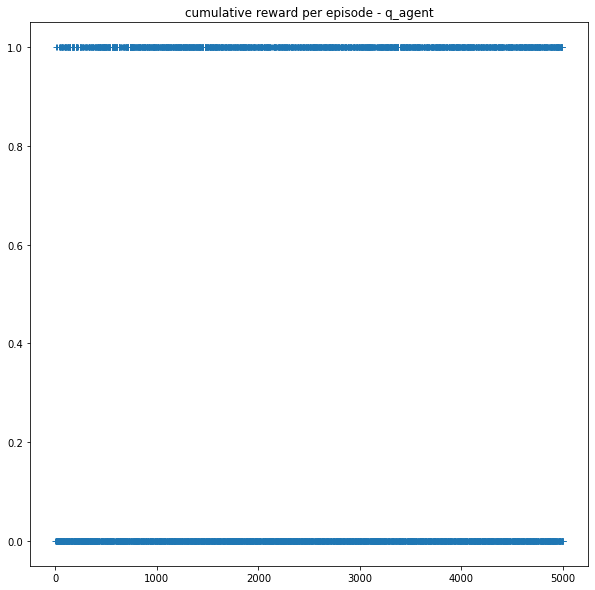

In [49]:
q_agent = MyQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - q_agent')

In [50]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

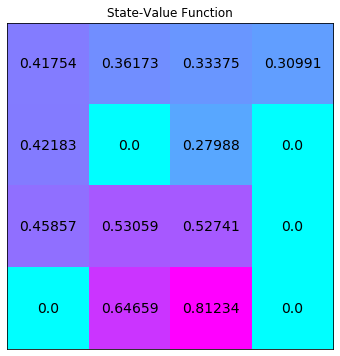

In [51]:
V = policy_evaluation(env, q_agent.policy)
plot_values_lake(V)

In [52]:
V.sum()

5.100116629064201

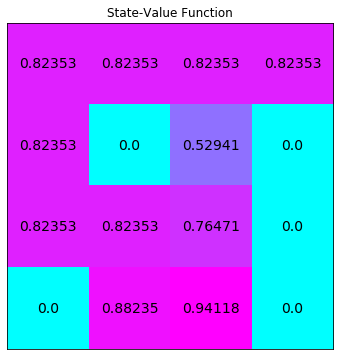

8.882351322605881

In [53]:
policy_best, V_best = value_iteration(env)
plot_values_lake(V_best)
V_best.sum()

In [54]:
#Question: Why we don't have the optimal policy?

In [57]:
q_policy_no_eps = np.zeros(q_agent.policy.shape)
q_policy_no_eps[np.arange(len(q_policy_no_eps)), q_agent.policy.argmax(axis=1)] = 1

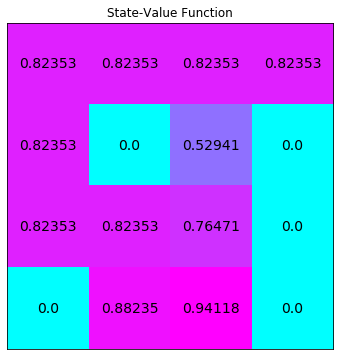

8.882351322605881

In [64]:
V = policy_evaluation(env, q_policy_no_eps)
plot_values_lake(V)
V_best.sum()

### keep in mind:
\begin{aligned}
MDP \rightarrow V(S_t) &\leftarrow \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})] \\
MC \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_{t+1})\\
TD \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}